In [1]:
import re
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from urllib.parse import urlparse
from sklearn import preprocessing
import tldextract
%matplotlib inline
import random
import gc
import xgboost as xgb
from sklearn import svm
from tensorflow import keras
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D
from sklearn import metrics

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
#setting a random seed value
seed_value=1234

os.environ['PYTHONHASHSEED']=str(seed_value)

random.seed(seed_value)

In [3]:
df=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_1.csv")
df2=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_2.csv")
df3=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_3.csv")

In [4]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df2.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [6]:
df3.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [8]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  450176 non-null  int64 
 1   url         450176 non-null  object
 2   label       450176 non-null  object
 3   result      450176 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 13.7+ MB


In [10]:
df2.describe()

,Unnamed: 0,result
count,450176.000000,450176.000000
mean,225087.500000,0.231994
std,129954.761728,0.422105
min,0.000000,0.000000
25%,112543.750000,0.000000
50%,225087.500000,0.000000
75%,337631.250000,0.000000
max,450175.000000,1.000000


In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     420464 non-null  object
 1   label   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [12]:
df3.describe()

,url,label
count,420464,420464
unique,411247,2
top,d11m2p9mpffp32.cloudfront.net/main/web_zt.exe,good
freq,27,344821


Preprocessing the data

In [13]:
df['type']=df['type'].replace({'phishing':1,'benign':0,'defacement':1,'malware':1})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.9+ MB


In [15]:
df['type'].value_counts()

0    428103
1    223088
Name: type, dtype: int64

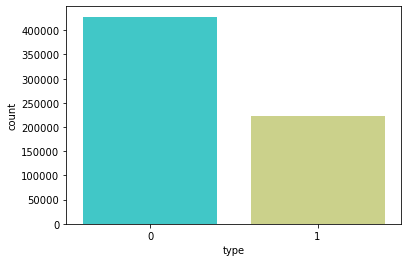

In [16]:
sns.countplot(x='type',data=df, palette='rainbow')
plt.show()

In [17]:
df2.drop(df2.columns[df2.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df2.drop('label',axis = 1, inplace = True)
df2=df2.rename(columns={'result': 'type'})

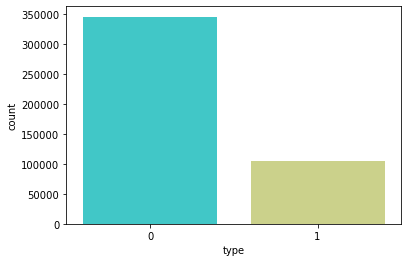

In [18]:
sns.countplot(x='type',data=df2, palette='rainbow')
plt.show()

In [19]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     420464 non-null  object
 1   label   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [20]:
df3=df3.rename(columns={'label': 'type'})
df3['type']=df3['type'].replace({'bad':1,'good':0})

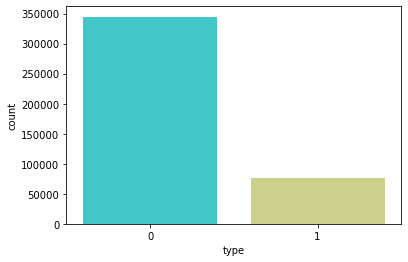

In [21]:
sns.countplot(x='type',data=df3, palette='rainbow')
plt.show()

In [22]:
# df=df.append(df2)
# df=df.append(df3)

In [23]:
df.drop_duplicates(keep='first',inplace=True)

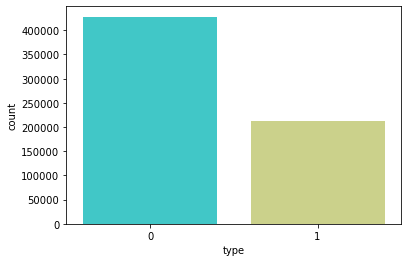

In [24]:
sns.countplot(x='type',data=df, palette='rainbow')
plt.show()

In [25]:
#Feature Extraction methods

#returns the length of the url
def http(s):
    return s.count('http')

#returns the count of http in the url
def https(s):
    return s.count('https')

#returns the count of www in the url
def www(s):
    return s.count('www')

#returns the count of digits in the url
def digit(s):
    return sum(i.isnumeric() for i in s)

#returns the count of alphabets in the url
def alpha(s):
    return sum(i.isalpha() for i in s)

#returns the count of special character's in the url
def spec_char(s):
    return sum((not(i.isalpha()) and not(i.isnumeric())) for i in s)

#returns the count of / in the url
def spec_char_1(s):
    return s.count('/')

#returns the count of ! in the url
def spec_char_2(s):
    return s.count('!')

#returns the count of . in the url
def spec_char_3(s):
    return s.count('.')

#returns the count of @ in the url    
def spec_char_4(s):
    return s.count('@')

#returns the count of % in the url
def spec_char_5(s):
    return s.count('%')

#returns the count of ? in the url
def spec_char_6(s):
    return s.count('?')

#returns the count of = in the url
def spec_char_7(s):
    return s.count('=')

#returns the count of + in the url
def spec_char_8(s):
    return s.count('+')

#returns the count of - in the url
def spec_char_9(s):
    return s.count('-')

#returns the count of & in the url
def spec_char_10(s):
    return s.count('&')

def spec_char_11(s):
    return s.count('~')

def query_length(s):
    return len(urlparse(s).query)

#returns the domain of the url
def dom_suffix(s):
    domains={'com':1,'edu':2,'org':3,'net':4,'onion':5,'in':6}
    s=tldextract.extract(s).suffix
    if s in domains.keys():
        return domains[s]
    else:
        return 0

#returns the length of the domain
def dom_length(s):
    return len(tldextract.extract(s).domain)

#returns the length of the sub_domain
def subdom_length(s):
    return len(tldextract.extract(s).subdomain)

#returns the length of the url path
def path_length(s):
    return len(urlparse(s).path)

#returns 1 if url contains a query
def has_query(s):
    if len(urlparse(s).query)==0:
        return 0
    else:
        return 1

def ip(s):
    has_ip=re.search('(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
    '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
    '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
    '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', s)
    if has_ip:
        return 1
    else:
        return 0

def extension(s):
    if '.htm' in s:
        return 1
    elif '.html' in s:
        return 2
    elif '.js' in s:
        return 3
    elif '.css' in s:
        return 4
    elif '.exe' in s:
        return 5
    elif '.php' in s:
        return 6
    elif '.py' in s:
        return 7
    else:
        return 0

In [26]:
#Extracting the feautures

df['len']=df['url'].apply(lambda s : len(str(s)))

df['http_count']=df['url'].apply(lambda s : http(s))

df['https_count']=df['url'].apply(lambda s : https(s))

df['www']=df['url'].apply(lambda s : www(s))

df['digit_count']=df['url'].apply(lambda s: digit(s))

df['alpha_count']=df['url'].apply(lambda s: alpha(s))

df['spec_char_count']=df['url'].apply(lambda s: spec_char(s))

df['/']=df['url'].apply(lambda s: spec_char_1(s))

df['!']=df['url'].apply(lambda s: spec_char_2(s))

df['.']=df['url'].apply(lambda s: spec_char_3(s))

df['@']=df['url'].apply(lambda s: spec_char_4(s))

df['%']=df['url'].apply(lambda s: spec_char_5(s))

df['?']=df['url'].apply(lambda s: spec_char_6(s))

df['=']=df['url'].apply(lambda s: spec_char_7(s))

df['+']=df['url'].apply(lambda s: spec_char_8(s))

df['-']=df['url'].apply(lambda s: spec_char_9(s))

df['&']=df['url'].apply(lambda s: spec_char_10(s))

df['~']=df['url'].apply(lambda s: spec_char_11(s))

df['dom_suffix']=df['url'].apply(lambda s: dom_suffix(s))

df['dom_length']=df['url'].apply(lambda s: dom_length(s))

df['subdom_length']=df['url'].apply(lambda s: subdom_length(s))

df['query']=df['url'].apply(lambda s: has_query(s))

df['extension']=df['url'].apply(lambda s: extension(s))

df['ip']=df['url'].apply(lambda s: ip(s))

df.drop('url',axis = 1, inplace = True)

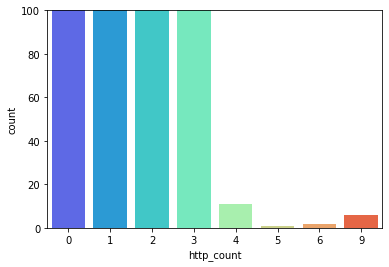

In [27]:
plot=sns.countplot(x='http_count',data=df, palette='rainbow')
plot.set(ylim=(0, 100))
plt.show()

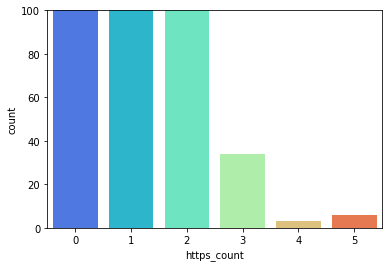

In [28]:
plot=sns.countplot(x='https_count',data=df, palette='rainbow')
plot.set(ylim=(0, 100))
plt.show()

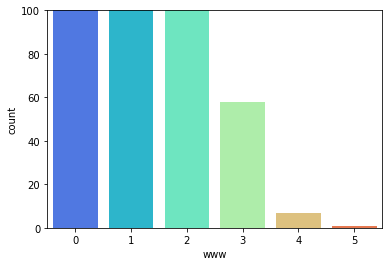

In [29]:
plot=sns.countplot(x='www',data=df, palette='rainbow')
plot.set(ylim=(0, 100))
plt.show()

In [30]:
#Normalising the feauture values to between 0 and 1
x=['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','&','~','dom_suffix','dom_length','subdom_length','query','extension','ip']
min_max_scaler = preprocessing.MinMaxScaler()
column_names_to_normalize = x
x = df[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
df[column_names_to_normalize] = df_temp

In [31]:
x=df[['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','extension','ip']]
y=df['type']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle='True',stratify=y)

In [33]:
#Logistic Regression Classifier
model=LogisticRegression(solver='lbfgs',max_iter=1000)
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

In [34]:
model.score(x_test,y_test)

0.8981321895106259

In [35]:
pred=model.predict(x_test)

In [36]:
#Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

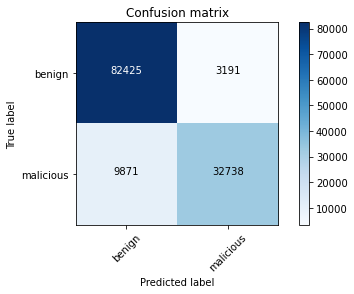

In [37]:
cm = metrics.confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [38]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93     85616
           1       0.91      0.77      0.83     42609

    accuracy                           0.90    128225
   macro avg       0.90      0.87      0.88    128225
weighted avg       0.90      0.90      0.90    128225



In [39]:
#Decision Tree Classifier
model_1=DecisionTreeClassifier()
model_1.fit(x_train,y_train)

DecisionTreeClassifier()

In [40]:
model_1.score(x_test,y_test)

0.9710976798596218

In [41]:
pred1=model_1.predict(x_test)

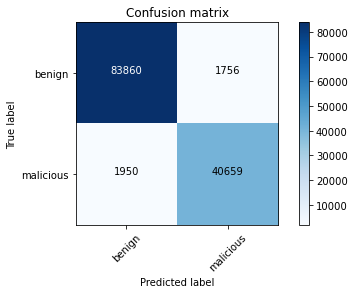

In [42]:
cm = metrics.confusion_matrix(y_test, pred1, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [43]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     85616
           1       0.96      0.95      0.96     42609

    accuracy                           0.97    128225
   macro avg       0.97      0.97      0.97    128225
weighted avg       0.97      0.97      0.97    128225



In [44]:
#Feature Importance
w=model_1.feature_importances_

/var/folders/6t/fjr9gh2x3kzfp_x8d04mv8gm0000gn/T/ipykernel_73385/118279047.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_yticklabels(s.get_yticklabels())


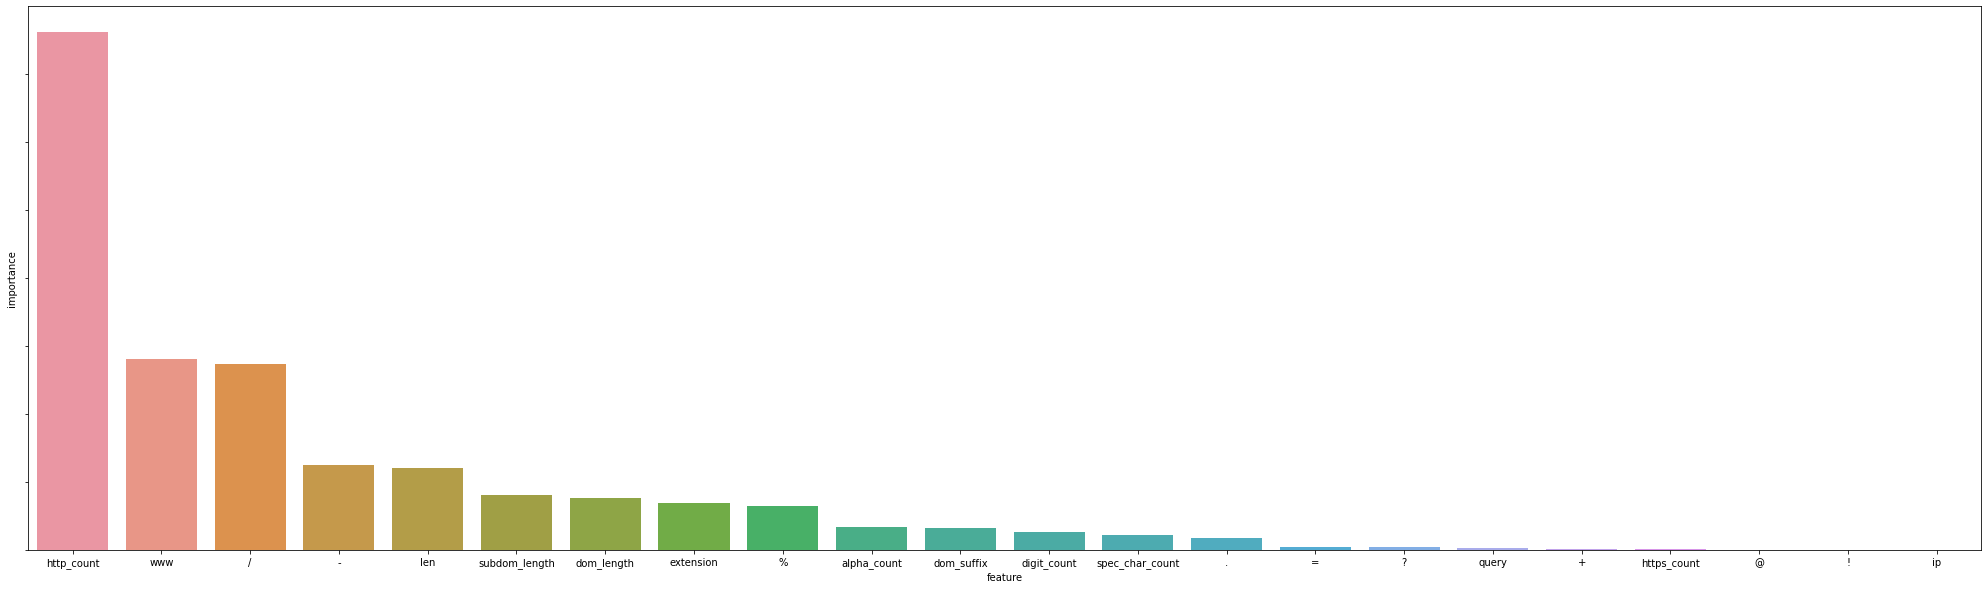

In [45]:
feature_names=['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','extension','ip']
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = w
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
#ax = feature_importance.plot.barh(x='feature', y='importance')
plt.figure(figsize = (35,10))
s = sns.barplot(x='feature', y='importance',data=feature_importance)
s.set_yticklabels(s.get_yticklabels())
plt.show()

In [53]:
#XgBoost Classifier
model_3=xgb.XGBClassifier()
model_3.fit(x_train,y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:15] WARNING: /private/var/folders/6t/fjr9gh2x3kzfp_x8d04mv8gm0000gn/T/pip-install-y0vm59pd/xgboost_9fb7486255a9441d88b43152e370bd50/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
model_3.score(x_test,y_test)

0.9754260089686099

In [55]:
pred3=model_3.predict(x_test)

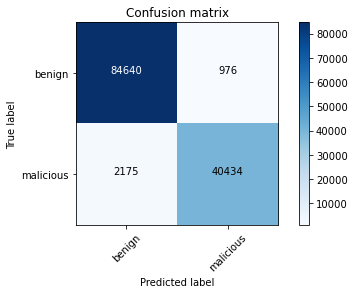

In [56]:
cm = metrics.confusion_matrix(y_test, pred3, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [57]:
print(classification_report(y_test,pred3))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85616
           1       0.98      0.95      0.96     42609

    accuracy                           0.98    128225
   macro avg       0.98      0.97      0.97    128225
weighted avg       0.98      0.98      0.98    128225



In [58]:
w_3=model_3.feature_importances_

/var/folders/6t/fjr9gh2x3kzfp_x8d04mv8gm0000gn/T/ipykernel_73385/141821707.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_yticklabels(s.get_yticklabels())


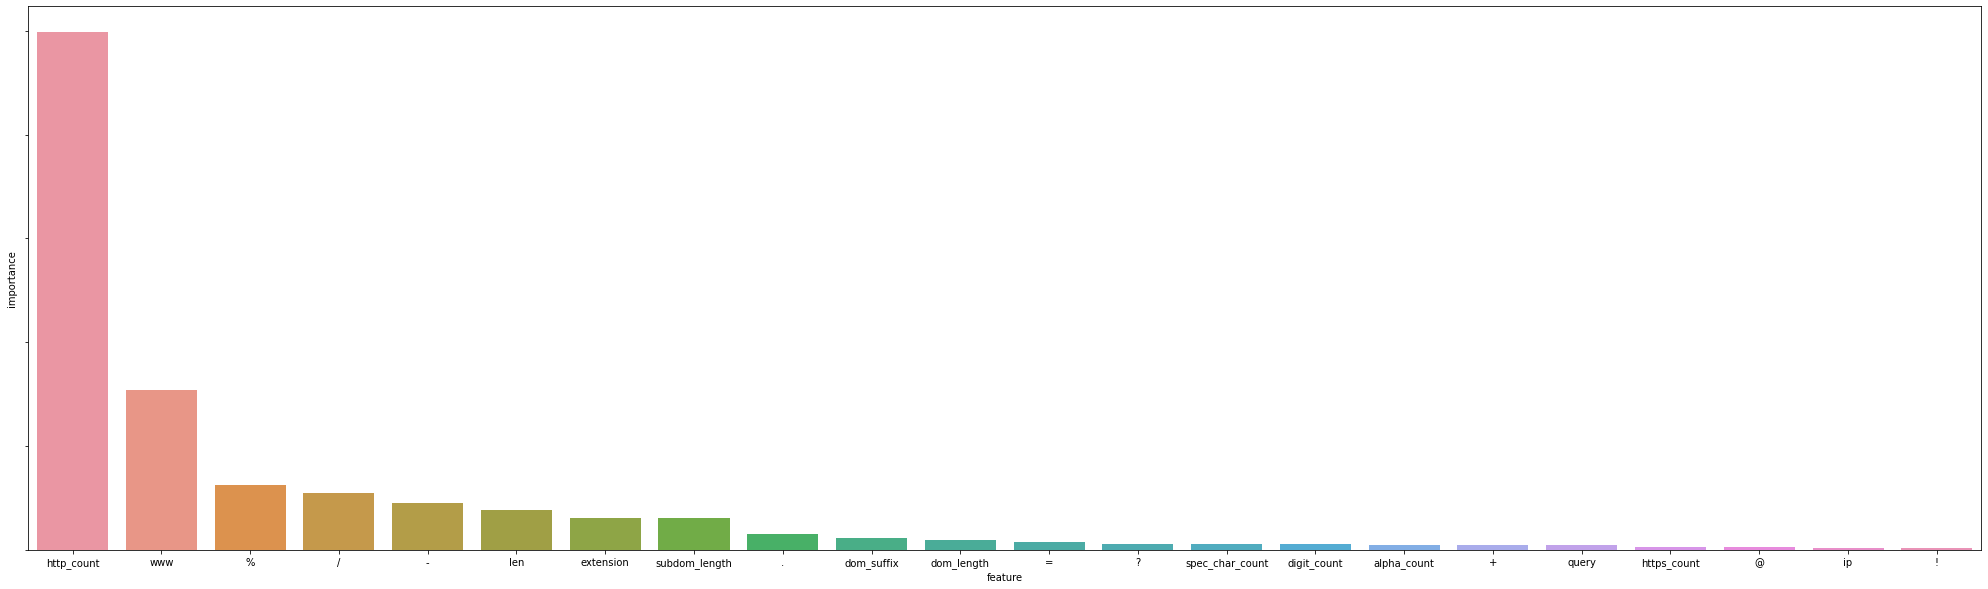

In [59]:
feature_names=['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','extension','ip']
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = w_3
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
#ax = feature_importance.plot.barh(x='feature', y='importance')
plt.figure(figsize = (35,10))
s = sns.barplot(x='feature', y='importance',data=feature_importance)
s.set_yticklabels(s.get_yticklabels())
plt.show()

In [60]:
#Random Forest Classifier
model_4=RandomForestClassifier(n_estimators=100)
model_4.fit(x_train,y_train)

RandomForestClassifier()

In [61]:
model_4.score(x_test,y_test)

0.9787326964320531

In [62]:
pred4=model_4.predict(x_test)

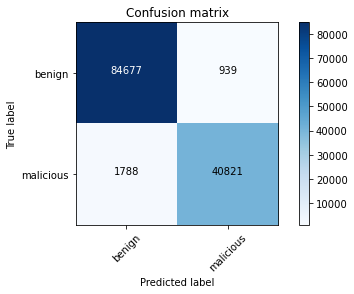

In [63]:
cm = metrics.confusion_matrix(y_test, pred4, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [64]:
w_4=model_4.feature_importances_

In [65]:
print(classification_report(y_test,pred4))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     85616
           1       0.98      0.96      0.97     42609

    accuracy                           0.98    128225
   macro avg       0.98      0.97      0.98    128225
weighted avg       0.98      0.98      0.98    128225



/var/folders/6t/fjr9gh2x3kzfp_x8d04mv8gm0000gn/T/ipykernel_73385/1398555877.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_yticklabels(s.get_yticklabels())


[Text(0, 0.0, ''),
 Text(0, 0.05, ''),
 Text(0, 0.1, ''),
 Text(0, 0.15000000000000002, ''),
 Text(0, 0.2, ''),
 Text(0, 0.25, '')]

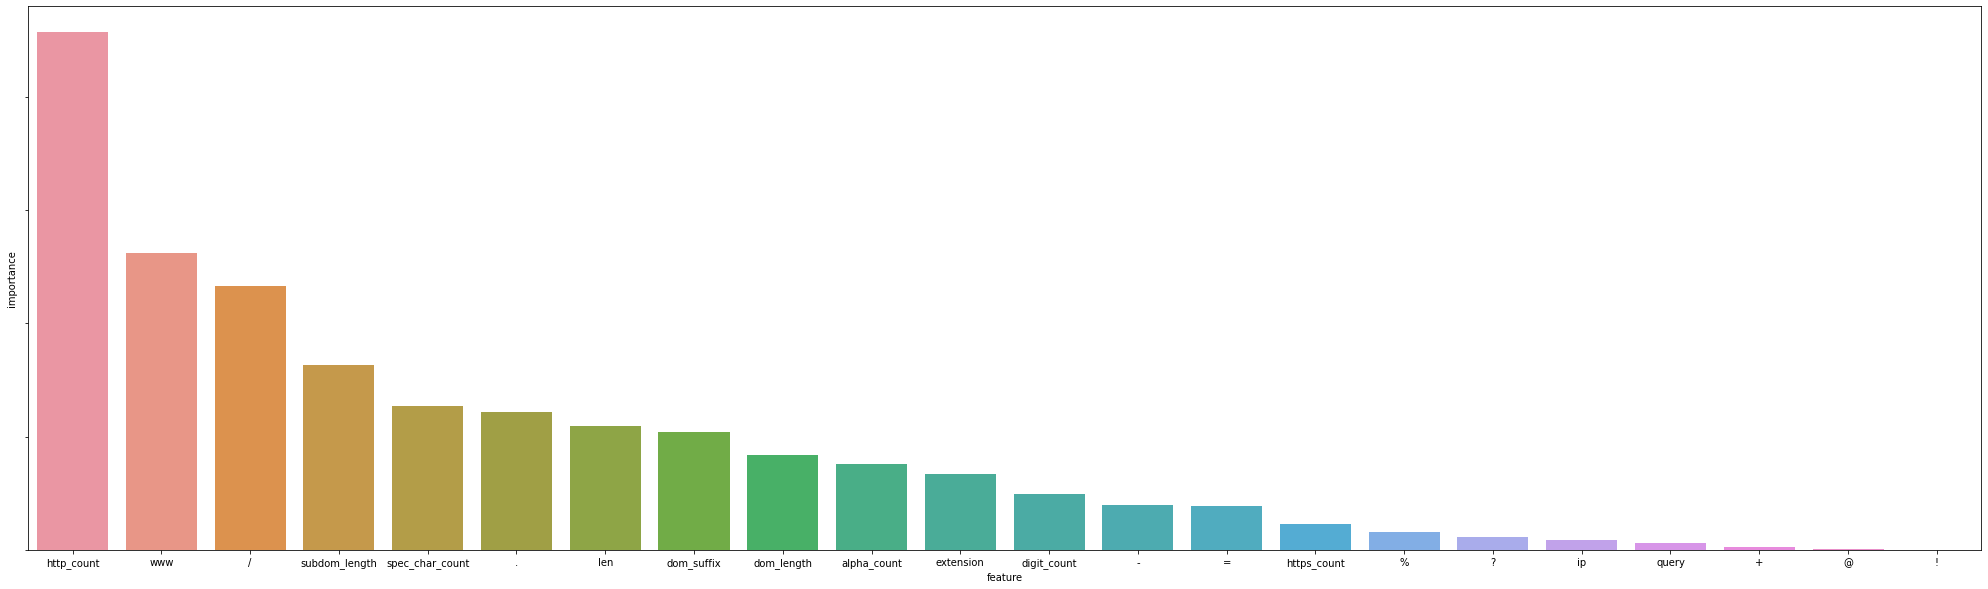

In [66]:
feature_names=['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','extension','ip']
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = w_4
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
#ax = feature_importance.plot.barh(x='feature', y='importance')
plt.figure(figsize = (35,10))
s = sns.barplot(x='feature', y='importance',data=feature_importance)
s.set_yticklabels(s.get_yticklabels())

In [67]:
df_test=pd.DataFrame()
df_test['url']=['www.reddit.com','www.facebook.com','www.amazon.com','https://9779.info/%E5%B9%BC%E5%84%BF%E7%B2%BD%E5%8F%B6%E8%B4%B4%E7%94%BB/']

In [68]:
df_test['len']=df_test['url'].apply(lambda s : len(str(s)))

df_test['http_count']=df_test['url'].apply(lambda s : http(s))

df_test['https_count']=df_test['url'].apply(lambda s : https(s))

df_test['www']=df_test['url'].apply(lambda s : www(s))

df_test['digit_count']=df_test['url'].apply(lambda s: digit(s))

df_test['alpha_count']=df_test['url'].apply(lambda s: alpha(s))

df_test['spec_char_count']=df_test['url'].apply(lambda s: spec_char(s))

df_test['/']=df_test['url'].apply(lambda s: spec_char_1(s))

df_test['!']=df_test['url'].apply(lambda s: spec_char_2(s))

df_test['.']=df_test['url'].apply(lambda s: spec_char_3(s))

df_test['@']=df_test['url'].apply(lambda s: spec_char_4(s))

df_test['%']=df_test['url'].apply(lambda s: spec_char_5(s))

df_test['?']=df_test['url'].apply(lambda s: spec_char_6(s))

df_test['=']=df_test['url'].apply(lambda s: spec_char_7(s))

df_test['+']=df_test['url'].apply(lambda s: spec_char_8(s))

df_test['-']=df_test['url'].apply(lambda s: spec_char_9(s))

df_test['dom_suffix']=df_test['url'].apply(lambda s: dom_suffix(s))

df_test['dom_length']=df_test['url'].apply(lambda s: dom_length(s))

df_test['subdom_length']=df_test['url'].apply(lambda s: subdom_length(s))

df_test['query']=df_test['url'].apply(lambda s: has_query(s))

df_test['extension']=df_test['url'].apply(lambda s: extension(s))

df_test['ip']=df_test['url'].apply(lambda s: ip(s))

df_test.drop('url',axis = 1, inplace = True)


In [69]:
df_test.head()

,len,http_count,https_count,www,digit_count,alpha_count,spec_char_count,/,!,.,...,?,=,+,-,dom_suffix,dom_length,subdom_length,query,extension,ip
0,14,0,0,1,0,12,2,0,0,2,...,0,0,0,0,1,6,3,0,0,0
1,16,0,0,1,0,14,2,0,0,2,...,0,0,0,0,1,8,3,0,0,0
2,14,0,0,1,0,12,2,0,0,2,...,0,0,0,0,1,6,3,0,0,0
3,73,1,1,0,20,29,24,4,0,1,...,0,0,0,0,0,4,0,0,0,0


In [70]:
prediction=model_3.predict(df_test)

In [71]:
prediction

array([0, 0, 0, 1])